Created 8/10/2025
Written by Shawn Newman (With code stolen from Steven Corum and Alex Seaver)

In [1]:
import matplotlib.pyplot as plt  # Plotting graphs and visualizing data
from matplotlib.ticker import LogLocator # Used for ticks in logarithmic plots
import numpy as np               # Numerical operations, particularly with arrays
import pandas as pd              # Data manipulation and analysis
import os
import importlib.util
quiet=True
current_dir = "."
target_file = "ICASL.py"
target_name = "ICASL"
while True:
    if not quiet: print(current_dir)
    # Check if ICASL is in the current directory
    ICASL_path = os.path.join(current_dir, target_file)
    if not quiet: print(ICASL_path)
    if os.path.isfile(ICASL_path):
        # Loads ICASL.py
        spec = importlib.util.spec_from_file_location(target_name, ICASL_path)
        ICASL = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(ICASL)
        break
    else:
        # Move one level up
        parent_dir = os.path.join(current_dir, "..")
        if not quiet: print(parent_dir)
        if current_dir == parent_dir:  # Reached the root directory
            raise ValueError("ICASL.py not found")
        else:
            current_dir = parent_dir
ICASL.test()

ICASL is loaded!


Layer 1 of keys for Temp: [27, 125, -55, -180]
Layer 2 of keys for VREF: [0.6, 0.7, 0.8, 0.9, 1.0]
Final dataframe columns: [time, VREF]

Layer 1 of keys for Temp: [27, 125, -55, -180]
Layer 2 of keys for VREF: [0.6, 0.7, 0.8, 0.9, 1.0]
Final dataframe columns: [time, VOUT]

Layer 1 of keys for Temp: [-180, -55, 27, 125]
Final dataframe columns: [time, IL]



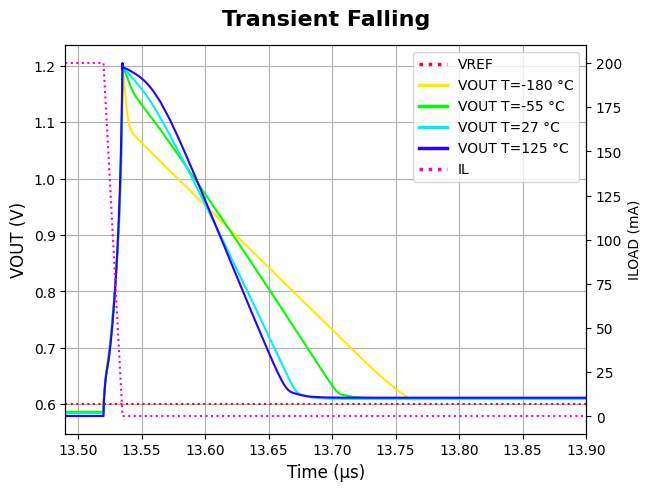

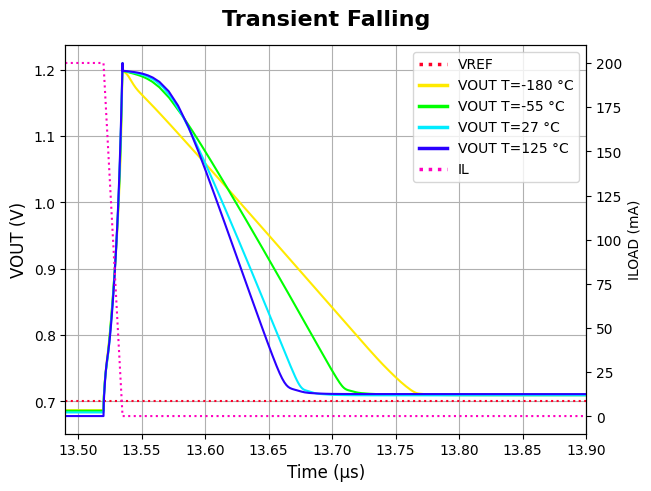

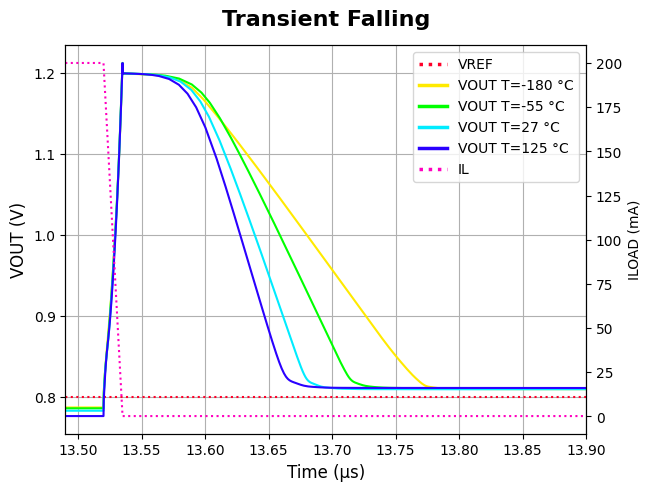

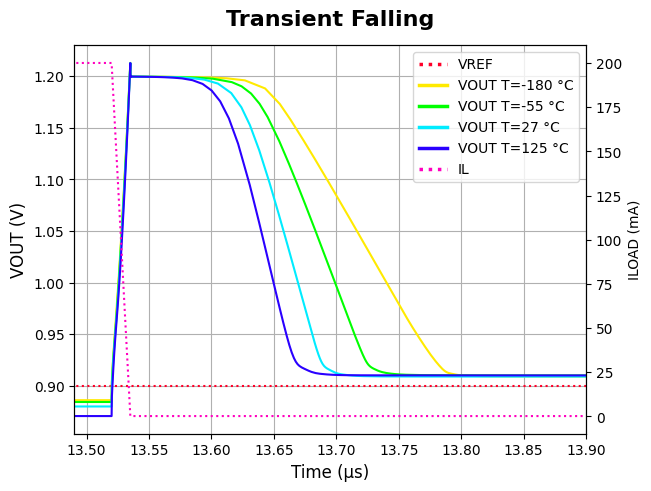

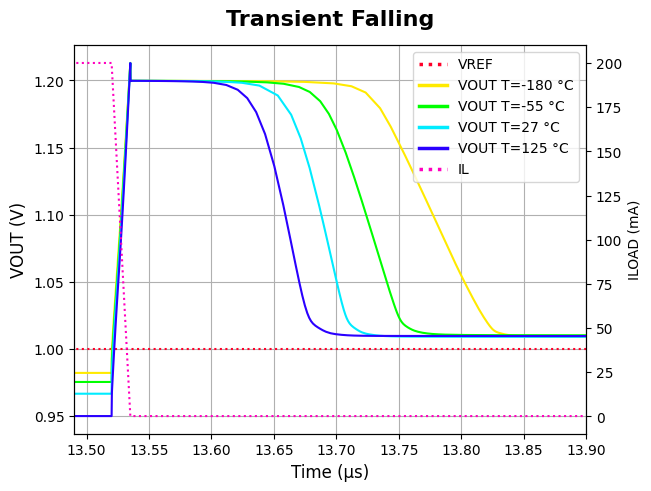

In [3]:
sim_dir = "Sim_Data"
tran_dir = os.path.join(sim_dir, "Transient_Sims")
VREF_data, [temps, VREFs] = ICASL.read_cadence_csv(os.path.join(tran_dir, "TI_RLDO_VREF.csv"), ["Temp", "VREF"], new_x_label = "time", new_y_label = "VREF")
VOUT_data, [temps, VREFs] = ICASL.read_cadence_csv(os.path.join(tran_dir, "TI_RLDO_VOUT.csv"), ["Temp", "VREF"], new_x_label = "time", new_y_label = "VOUT")
IL_data, [temps] = ICASL.read_cadence_csv(os.path.join(tran_dir, "TI_RLDO_IL.csv"), ["Temp"], new_x_label = "time", new_y_label = "IL")

# Example Usage:
VREF_data[27][0.6]

#plt.gca().autoscale(enable=False, axis='x')
#plt.ticklabel_format(style='plain', axis='x')

def transient_plot(start_data, start_plot, end_plot, end_data, legend_location, type):
    for VREF in VREFs:
        ts = 1e-6 # Time scale
        fig, ax1 = ICASL.start_plot(f"Transient {type}", f"Time ({ICASL.prefix(ts)}s)", "VOUT (V)", style="b")
        ax2 = ax1.twinx()

        VREF_df = VREF_data[27][VREF]
        VREF_df = ICASL.limit_data(VREF_df, "time", start_data*ts, end_data*ts)
        ax1.ticklabel_format(useOffset=False)
        ax1.plot(VREF_df["time"]/ts, VREF_df["VREF"], label = f"VREF", linestyle='dotted')

        IL_df = IL_data[27]
        IL_df = ICASL.limit_data(IL_df, "time", start_data*ts, end_data*ts)
        ax2.set_ylabel(f"ILOAD ({ICASL.prefix(IL_df['IL'])}A)")
        ax2.plot(IL_df["time"]/ts, ICASL.scale(IL_df["IL"]), label = f"IL", linestyle='dotted')

        for temp in temps:
            VOUT_df = VOUT_data[temp][VREF]
            VOUT_df = ICASL.limit_data(VOUT_df, "time", start_data*ts, end_data*ts)
            ax1.plot(VOUT_df["time"]/ts, VOUT_df["VOUT"], label = f"VOUT T={temp} °C")
            
        ax1.set_xlim(start_plot, end_plot)
        ICASL.finish_plot(fig, [ax1,ax2], save_dir="Sim_Plots", save_file=f"Tran_{type}_VREF={VREF}V.png", cm=plt.get_cmap('gist_rainbow'), 
                        show=True, legend_style=f"ck{legend_location}")
        
#transient_plot(10, 10.98, 11.15, 11.5, "lr", "Rising")
transient_plot(12, 13.49, 13.9, 15, "ur", "Falling")